In [0]:
# Import some useful packages 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from ipywidgets import interact, IntSlider, FloatSlider

In [0]:
# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense,Flatten

# Layers for CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [0]:
# Import the data set
from tensorflow.keras.datasets import mnist
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Reshape size
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Normalize the range of featurs
x_train = x_train / 255
x_test = x_test / 255

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [0]:
# Build the VAE model. I set three layers for encoder and decoder individually
# activation function is setted as relu, batch_size = 256, epochs = 25

x = Input(shape=(784,))
enc_1 = Dense(128, activation='relu')
enc_2 = Dense(64, activation='relu')
enc_3 = Dense(32, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(128, activation='relu')
dec_2 = Dense(256, activation='relu')
dec_1 = Dense(784, activation='relu')

In [0]:
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [0]:
# by default, random_normal has mean = 0 and std = 1.0
def sampling(args): # define the sampling function 
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
x_hat = dec_1(dec_2(dec_3(z)))

In [0]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
______________________________________________________________________________________________

In [0]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer='adam')

In [0]:
VAE.fit(x_train,batch_size=256,epochs=20)

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 52.2040
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 45.4656
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 43.4068
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 42.0783
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 41.1750
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 40.4782
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 40.0726
Epoch 8/20
235/235 [==============================] - 1s 5ms/step - loss: 39.4713
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 39.2275
Epoch 10/20
235/235 [==============================] - 1s 5ms/step - loss: 38.9016
Epoch 11/20
235/235 [==============================] - 1s 5ms/step - loss: 38.6819
Epoch 12/20
235/235 [==============================] - 1s 5ms/step - loss: 38.3404
Epoch 13/20
2

In [0]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 110,882
Trainable params: 110,882
Non-trainable params: 0
_________________________________________________________________


In [0]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [0]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


In [0]:
idx = np.random.randint(x_train.shape[0])

In [0]:
indices = np.random.randint(x_train.shape[0], size=5000)

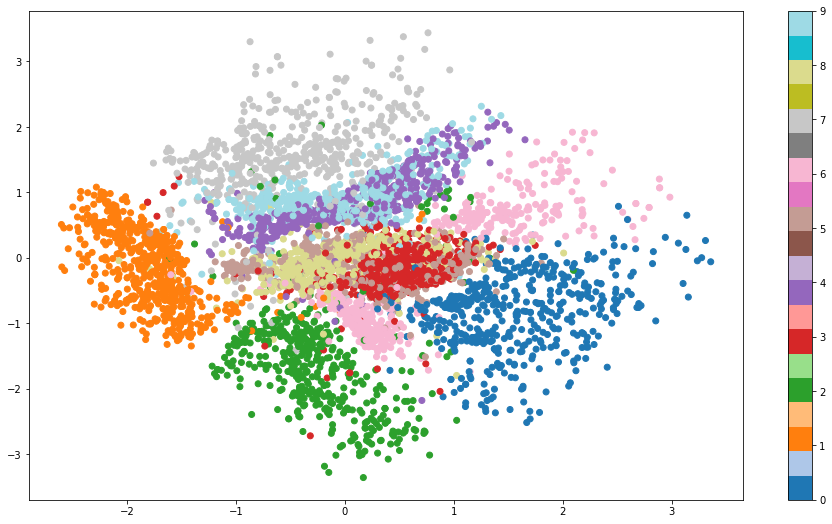

In [0]:
VAE_latents = VAE_Encoder.predict(x_train[indices])
plt.figure(figsize=(16, 9))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n=16
digit_size=28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

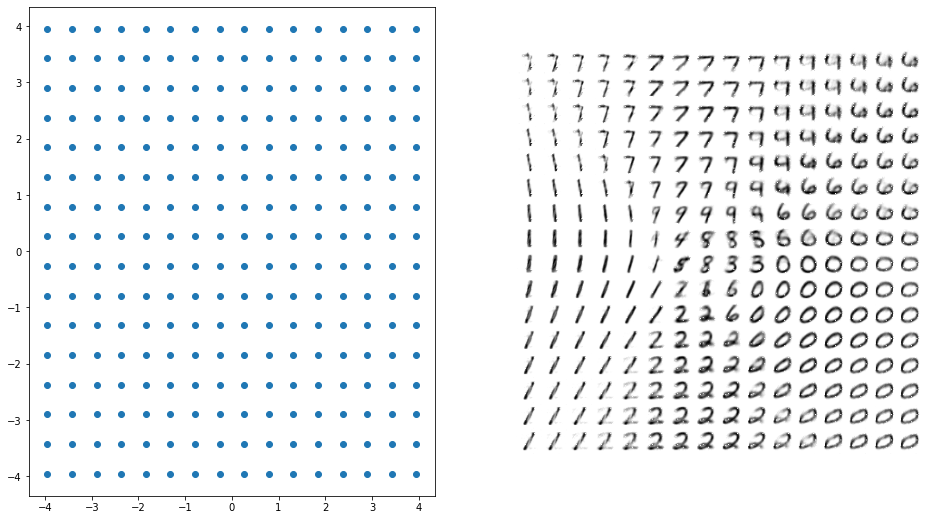

In [0]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# Conclusion:

## The math details behind VAE are not that easy for me to fully understand. I am not really sure how to tune the parameters, that can make the model perform better. 

##I take the code demonstration on the class as the inferences and make some adjustment. For example, I change the  activation function, the dense of the layers and the batch size and so on. Hope to learn deeper in the future : )